<br>

# This next cell contains methods for generating data for training the feature extractor and data for environments 1, 2, and 3 by adding color to the MNIST images and binarizing the image labels.

In [1]:
import numpy as np
import torch
from torch import nn, optim, autograd
import torchvision.transforms as transforms
from torchvision import datasets
from torch import nn, optim, autograd
import pandas as pd
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from PIL import Image
import matplotlib.pyplot as plt

grayscale_model = False
hidden_dim = 256

# Method for coloring MNIST image as either red or green.
#  Method adapted from https://github.com/reiinakano/invariant-risk-minimization
def add_color_to_MNIST(arr, red):
    """Converts grayscale image to either red or green"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if red:
        arr = np.concatenate([arr, np.zeros((h, w, 2), dtype=dtype)], axis=2)
    else:
        arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),arr, np.zeros((h, w, 1), dtype=dtype)], axis=2)
    return arr


    
# Method for generating different environments based on the percentage of the color distribution specified    
def generate_environments(images, labels, p=0):
    # Generating colors for images based on the specified percentage p
    color_indeces = torch.arange(0,len(images))
    colors = (color_indeces < p*(len(color_indeces))).float()
    colors_bool = colors[torch.randperm(len(color_indeces))]
    colors = colors[torch.randperm(len(color_indeces))].float()

    labels_target = []
    colors_target =[]
    env_set_list = []
    env_set_PIL = []
    for i in range(len(images)):
        if i % 10000 == 0:
            print(f'Processing image {i}/{len(images)}')
        im_array = np.array(images[i])

        # Assign a binary label y to the image based on the digit (0 [0-4] or 1 [5-9])
        binary_label = 0 if labels[i] < 5 else 1

        # Color the image red or green
        color_red = colors_bool[i]
        colored_arr = add_color_to_MNIST(im_array, red=color_red)
        
        # convert to PIL image format 
        PIL_img = Image.fromarray(colored_arr)
        
        # transform = transforms.Compose([transforms.PILToTensor()])
        transform = transforms.Compose([
            transforms.Resize(14),
            transforms.CenterCrop(14),
            transforms.ToTensor()
        ])

        # Convert the PIL image to Torch tensor
        img_tensor = transform(PIL_img)
        
        env_set_list.append(img_tensor.numpy())       
        # env_set_PIL contains images that will be used to generate plots later
        env_set_PIL.append((Image.fromarray(colored_arr), str(binary_label)+" C: "+str(int(colors_bool[i].item()) )))
        labels_target.append(binary_label)
        colors_target.append(colors[i])

    # Convert to torch tensor
    env_set_torch = torch.Tensor(env_set_list)
    labels_target = torch.Tensor(labels_target)
    colors_target = torch.Tensor(colors_target)
    
    # combining labels and colors into one 2D array where 1st column is labels and second column is colors
    labels_and_colors_df = pd.DataFrame(labels_target.numpy())
    labels_and_colors_df["1"]= colors_target.numpy()
    labels_and_colors_np = labels_and_colors_df.to_numpy()
    labels_and_colors = torch.from_numpy(labels_and_colors_np)
    
    return {
      'images': (env_set_torch.float() / 255.).cpu(),
       # 'images': env_set_torch.float().cpu(),
      'labels': labels_target[:, None].cpu(),
      'colors': colors_target[:, None].cpu(),
      'labels_and_colors':labels_and_colors.cpu(),
      'images_for_plot': env_set_PIL
    }



<br>

# In the next two cells we download MNIST data, add color based on the environment, and plot some of the images. In the plotted images, L stands for Label and C stands for Color.

In [2]:

# Image plotting method adapted from https://github.com/reiinakano/invariant-risk-minimization
def plot_digit_images(dataset):
    fig = plt.figure(figsize=(13, 8))
    columns = 7
    rows = 3
    # ax enables access to manipulate each of subplots
    ax = []

    for i in range(columns * rows):
        img, label = dataset[i]
        # create subplot and append to ax
        ax.append(fig.add_subplot(rows, columns, i + 1))
        # set title
        ax[-1].set_title("L: " + str(label))  
        plt.imshow(img)

    plt.show() 

Processing image 0/60000
Processing image 10000/60000
Processing image 20000/60000
Processing image 30000/60000
Processing image 40000/60000
Processing image 50000/60000


/tmp/ipykernel_119818/26602046.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  env_set_torch = torch.Tensor(env_set_list)


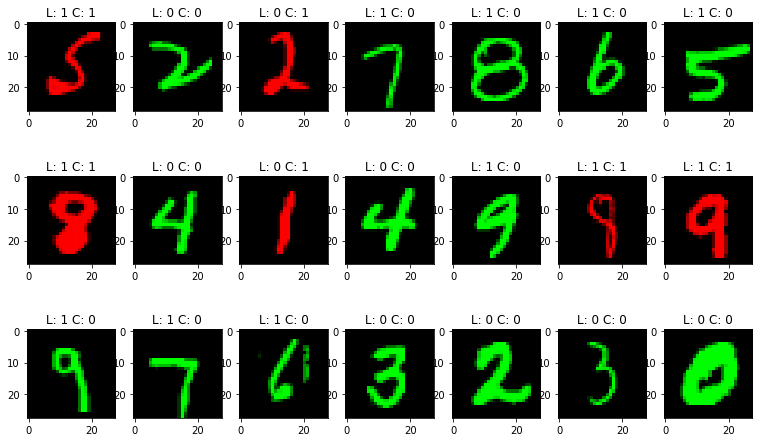

In [3]:
#Downloading MNIST data and splitting it into train and test sets, and a set that contains all of the dataset
mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
mnist_train = (mnist.data[:40000], mnist.targets[:40000])
mnist_test = (mnist.data[40000:], mnist.targets[40000:])
mnist_all = (mnist.data, mnist.targets)

# Shuffling the data
get_state = np.random.get_state()
np.random.shuffle(mnist_train[0].numpy())
np.random.set_state(get_state)
np.random.shuffle(mnist_train[1].numpy())

get_state = np.random.get_state()
np.random.shuffle(mnist_all[0].numpy())
np.random.set_state(get_state)
np.random.shuffle(mnist_all[1].numpy())

# Plot data
all_mnist = generate_environments(mnist_all[0], mnist_all[1], 0.5)['images_for_plot']
plot_digit_images(all_mnist)


# In this next cell we train the feature extractor and extract features from the train data (environments 1 and 2 data) and test data (environment 3 data) that we later use to train and test our prediction classifiers.

In [4]:
# Generating data for the environments: First element in the envs array is environment 1 data, second element is 
# environment 2 data, third element is environment 3 data, and fourth element is the data that we use to train the 
# feature extractor
envs = [
generate_environments(mnist_train[0][::2], mnist_train[1][::2], 0.1),
generate_environments(mnist_train[0][1::2], mnist_train[1][1::2], 0.2),
generate_environments(mnist_test[0], mnist_test[1], 0.9),
generate_environments(mnist_all[0], mnist_all[1], 0.5)]

# Model definition (using the MLP model definition from IRM)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        if grayscale_model:
            lin1 = nn.Linear(14 * 14, hidden_dim)
        else:
            lin1 = nn.Linear(3 * 14 * 14, hidden_dim)
        lin2 = nn.Linear(hidden_dim, hidden_dim)
        lin3 = nn.Linear(hidden_dim, 1)
        for lin in [lin1, lin2, lin3]:
            nn.init.xavier_uniform_(lin.weight)
            nn.init.zeros_(lin.bias)
        self._main = nn.Sequential(lin1, nn.ReLU(True), lin2, nn.ReLU(True), lin3)

    def forward(self, input):
        if grayscale_model:
            out = input.view(input.shape[0], 3, 14 * 14).sum(dim=1)
        else:
            out = input.view(input.shape[0], 3 * 14 * 14)
        out = self._main(out)
        return out


# train the model
def train_model(inputs, targets, model):
    # define the optimization
    criterion = torch.nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=0.0001)
    for i in range(500):
        optimizer.zero_grad()
        
        # predict y
        yhat = model(inputs)
        
        # compute label and color losses and then combine them
        label_loss = criterion(torch.sigmoid(yhat), targets[:,0].reshape(-1,1))
        color_loss = criterion(torch.sigmoid(yhat), targets[:,1].reshape(-1,1))
        loss = label_loss + color_loss
        
        loss.backward()
        optimizer.step()

# Method for evaluating the model
def evaluate_model(inputs, targets, model):
    
    # predict y
    yhat = torch.sigmoid(model(inputs))
    yhat = yhat.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    
    # Convert predicted y into 0s and 1s (binary)
    yhat = np.where(yhat < 0.5, 0, 1)
    yhat, targets = vstack(yhat), vstack(targets)
    
    # calculate accuracy
    label_acc = accuracy_score(targets[:,0], yhat)
    color_acc = accuracy_score(targets[:,1], yhat)
    # color_and_label_acc = accuracy_score(actuals, predictions)
    return label_acc, color_acc

mlp = MLP().cpu()

# Splitting the data used to train the feature extractor into train and test sets
# Train set (80%)
train_inputs = envs[3]['images'][:int(0.8*len(envs[3]['images']))]
train_targets =envs[3]['labels_and_colors'][:int(0.8*len(envs[3]['labels_and_colors']))]

# Test set (20%)
test_inputs = envs[3]['images'][int(0.8*len(envs[3]['images'])):]
test_targets =envs[3]['labels_and_colors'][int(0.8*len(envs[3]['labels_and_colors'])):]


# Train feature extractor
train_model(train_inputs, train_targets, mlp)

# Test feature extractor to obtain color and label accuracy
label_acc, color_acc = evaluate_model(test_inputs, test_targets, mlp)
print('Label Accuracy: %.3f' % label_acc)
print('Color Accuracy: %.3f' % color_acc)



# Method for extracting features from images
def extract_features(model, x,y, device = 'cpu'):
    model.eval()
    extracted_features = []  
    with torch.no_grad():
        x = x.to(device)
        h = model(x)
        extracted_features.append(h.cpu())       
    extracted_features = torch.cat(extracted_features, dim=0) 
    extracted_features = torch.flatten(extracted_features, 1)
    extracted_features_df = pd.DataFrame(extracted_features.numpy())
    extracted_features_df["target"] = y.cpu().numpy()
    return extracted_features_df

# Remove the last layer from the mlp model to use the model for feature extraction
new_model = nn.Sequential(*list(mlp.children())[:-1])

# combine environments 1 and 2 to form the training data
train_envs_1_and_2_inputs = torch.cat((envs[0]['images'],envs[1]['images']), 0)
train_envs_1_and_2_targets = torch.cat((envs[0]['labels'],envs[1]['labels']), 0)


# Test data from environment 3
test_inputs =envs[2]['images']
test_targets =envs[2]['labels']

# Dataframes contaning extracted features that we later use to build the prediction models.
train_extracted_features_df = extract_features(new_model,train_envs_1_and_2_inputs, train_envs_1_and_2_targets)
test_extracted_features_df = extract_features(new_model,test_inputs, test_targets)

Processing image 0/20000
Processing image 10000/20000
Processing image 0/20000
Processing image 10000/20000
Processing image 0/20000
Processing image 10000/20000
Processing image 0/60000
Processing image 10000/60000
Processing image 20000/60000
Processing image 30000/60000
Processing image 40000/60000
Processing image 50000/60000
Label Accuracy: 0.793
Color Accuracy: 0.504
